# Image Stitching using CNN Based Approach

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [19]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
        self.maxpool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        return x

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feature_extractor = FeatureExtractor().to(device)

In [21]:
class PanoramaGenerator(nn.Module):
    def __init__(self):
        super(PanoramaGenerator, self).__init__()
        # Define the neural network layers
        self.fc1 = nn.Linear(215296, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 128*128)  # Output size 1 for grayscale

    def forward(self, left_feat, right_feat):
        # Concatenate the left and right image features
        x = torch.cat((left_feat, right_feat), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Apply final fully connected layer without activation
        x = self.fc3(x)
        # Reshape the output to match image dimensions
        x = torch.reshape(x, (-1, 1, 128, 128))
        return x
panorama_generator = PanoramaGenerator().to(device)

In [22]:
import numpy as np
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Resize, Grayscale

# Assuming PanoramaDataset is defined as previously

class PanoramaDataset(Dataset):
    def __init__(self, segments_folder, pano_folder):
        self.segments_folder = segments_folder
        self.pano_folder = pano_folder
        self.panorama_files = [f for f in os.listdir(pano_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = Compose([
            Grayscale(),  # Convert to grayscale
            Resize((128, 128)),  # Resize to 128x128
            ToTensor()  # Convert images to PyTorch tensors
        ])

    def __len__(self):
        return len(self.panorama_files)

    def __getitem__(self, idx):
        panorama_file = self.panorama_files[idx]
        image_prefix = panorama_file.split(".")[0]
        
        left_image_path = os.path.join(self.segments_folder, f"{image_prefix}_left.jpg")
        right_image_path = os.path.join(self.segments_folder, f"{image_prefix}_right.jpg")
        panorama_image_path = os.path.join(self.pano_folder, panorama_file)

        left_image = Image.open(left_image_path).convert('L')
        right_image = Image.open(right_image_path).convert('L')
        panorama_image = Image.open(panorama_image_path).convert('L')

        left_image = self.transform(left_image)
        right_image = self.transform(right_image)
        panorama_image = self.transform(panorama_image)

        return left_image, right_image, panorama_image

# Initialize the dataset
segments_folder = "panorama_folder/Images_segments"
pano_folder = "panorama_folder/images-pano"
panorama_dataset = PanoramaDataset(segments_folder, pano_folder)

# Setting up parameters for dataset split
dataset_size = len(panorama_dataset)
indices = list(range(dataset_size))
split_train = int(np.floor(0.6 * dataset_size))
split_val = int(np.floor(0.8 * dataset_size))

# Randomizing indices
np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[:split_train], indices[split_train:split_val], indices[split_val:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(panorama_dataset, batch_size=64, sampler=train_sampler)
val_loader = DataLoader(panorama_dataset, batch_size=64, sampler=val_sampler)
test_loader = DataLoader(panorama_dataset, batch_size=64, sampler=test_sampler)

# Use the data loaders
for left_images, right_images, panorama_images in train_loader:
    print("Train Batch - Left images shape:", left_images.shape)
    break

for left_images, right_images, panorama_images in val_loader:
    print("Validation Batch - Left images shape:", left_images.shape)
    break

for left_images, right_images, panorama_images in test_loader:
    print("Test Batch - Left images shape:", left_images.shape)
    break


Train Batch - Left images shape: torch.Size([64, 1, 128, 128])
Validation Batch - Left images shape: torch.Size([64, 1, 128, 128])
Test Batch - Left images shape: torch.Size([64, 1, 128, 128])


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

# Move models to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feature_extractor = FeatureExtractor().to(device)
panorama_generator = PanoramaGenerator().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(panorama_generator.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    panorama_generator.train()
    running_loss = 0.0
    for left_img, right_img, panorama_img in train_loader:
        # Move input tensors to GPU
        left_img, right_img, panorama_img = left_img.to(device), right_img.to(device), panorama_img.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        left_feat = feature_extractor(left_img)
        right_feat = feature_extractor(right_img)
        outputs = panorama_generator(left_feat, right_feat)

        # Compute the loss
        loss = criterion(outputs, panorama_img)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation loop
    panorama_generator.eval()
    val_loss = 0.0
    with torch.no_grad():
        for left_img, right_img, panorama_img in val_loader:
            # Move input tensors to GPU
            left_img, right_img, panorama_img = left_img.to(device), right_img.to(device), panorama_img.to(device)

            left_feat = feature_extractor(left_img)
            right_feat = feature_extractor(right_img)
            outputs = panorama_generator(left_feat, right_feat)
            val_loss += criterion(outputs, panorama_img).item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}')

Epoch [1/20], Train Loss: 0.5429456382989883, Val Loss: 0.2859724313020706
Epoch [2/20], Train Loss: 0.23319413140416145, Val Loss: 0.18050872534513474
Epoch [3/20], Train Loss: 0.13934813253581524, Val Loss: 0.09693657606840134
Epoch [4/20], Train Loss: 0.07867053523659706, Val Loss: 0.06036481261253357
Epoch [5/20], Train Loss: 0.055126830004155636, Val Loss: 0.0507609061896801
Epoch [6/20], Train Loss: 0.04844100400805473, Val Loss: 0.04833303019404411
Epoch [7/20], Train Loss: 0.04587729461491108, Val Loss: 0.045593542978167534
Epoch [8/20], Train Loss: 0.04423114005476236, Val Loss: 0.042186664417386055
Epoch [9/20], Train Loss: 0.0425511933863163, Val Loss: 0.042768413200974464
Epoch [10/20], Train Loss: 0.04145174939185381, Val Loss: 0.04254128970205784
Epoch [11/20], Train Loss: 0.04132082872092724, Val Loss: 0.042683251202106476
Epoch [12/20], Train Loss: 0.0412118099629879, Val Loss: 0.03900830075144768
Epoch [13/20], Train Loss: 0.04080512374639511, Val Loss: 0.0396965201944

In [31]:
# Testing loop
panorama_generator.eval()
test_output=[]
test_loss = 0.0
with torch.no_grad():
    for left_img, right_img, panorama_img in test_loader:
        # Move input tensors to GPU
        left_img, right_img, panorama_img = left_img.to(device), right_img.to(device), panorama_img.to(device)

        left_feat = feature_extractor(left_img)
        right_feat = feature_extractor(right_img)
        outputs = panorama_generator(left_feat, right_feat)
        test_output.append(outputs)
        test_loss += criterion(outputs, panorama_img).item()

print(f'Test Loss: {test_loss/len(test_loader)}')

# Save the trained model
torch.save(panorama_generator.state_dict(), 'panorama_model.pth')

Test Loss: 0.04099251329898834


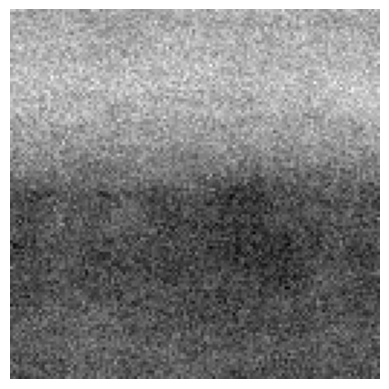

In [69]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

# Convert tensor to PIL Image for better handling if it's not normalized properly
image_tensor = test_output[0][0]
if image_tensor.min() < 0 or image_tensor.max() > 1:  # Assuming normalization might be off
    image_tensor = (image_tensor + 1) / 2  # Adjust if the data was normalized to [-1, 1]
image = ToPILImage()(image_tensor)

# Display the image
plt.imshow(image, cmap='gray')  # Use 'gray' for grayscale images
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()